<a href="https://colab.research.google.com/github/chavgova/predictNeuron_honor/blob/main/model_GRU_notnorm_5_5_noShuff_A06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import scipy.io
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, model_from_json

Load Data

In [2]:
label_data_folder = "/content/drive/MyDrive/Single channels data/Marked spike vectors"
raw_data_folder = "/content/drive/MyDrive/Single channels data/28102021_03_01_nbasal_0001/data"

In [3]:
os.chdir(raw_data_folder)
mat_files = glob.glob("*.mat")

data_dict = {}

for file in mat_files[:20]:
    # Load the .mat file using scipy.io.loadmat
    mat = scipy.io.loadmat(file)
    data_dict[file[27:30]] = np.concatenate(mat['data'])

print(data_dict.keys())
raw_df = pd.DataFrame.from_dict(data_dict, orient='columns')
raw_df

dict_keys(['A02', 'A05', 'A03', 'B07', 'B06', 'B01', 'B03', 'A06', 'B02', 'B05', 'C06', 'C03', 'C02', 'C05', 'C04', 'C01', 'D01', 'C07', 'D03', 'D02'])


,A02,A05,A03,B07,B06,B01,B03,A06,B02,B05,C06,C03,C02,C05,C04,C01,D01,C07,D03,D02
0,-1.921908,-4.485947,2.472312,-1.004966,2.960513,1.983918,1.373807,-2.959032,0.274880,-0.762878,0.031140,3.020819,5.462379,-2.471503,-1.556942,0.885219,-0.762241,-1.067851,0.336652,-5.341440
1,-1.250521,-6.561143,1.007469,-3.202231,0.824282,3.326691,1.495877,0.886183,-0.030296,1.190247,0.580456,2.959784,4.119606,-2.898749,-0.641415,-1.312047,-3.569858,-0.152323,2.106672,-4.609018
2,0.397428,-4.546983,2.167137,-1.981528,-1.311948,3.814972,1.312772,0.519972,-1.861351,1.922668,1.251843,0.335272,1.617165,2.167169,-1.556942,-3.875523,-0.823276,-5.889628,-0.212664,-2.716929
3,-4.546420,-3.936631,4.242332,-4.911216,-0.884702,4.364289,-2.166232,1.557570,-1.983421,0.274719,-0.701282,-3.448907,0.457497,1.190607,2.532413,-4.852086,-8.208530,1.922872,0.214582,1.921743
4,-2.715365,-7.415635,4.181297,-2.103599,3.815005,1.068390,3.449002,-0.334520,0.702126,4.791321,-0.884388,2.532538,-1.190453,0.397150,-0.641415,1.800746,0.397427,0.458028,-0.212664,-1.130015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998995,0.153287,-1.006944,-2.532570,-0.821860,3.021548,3.143586,0.641385,-10.893602,1.983864,1.190247,-3.203724,-2.777521,-4.486351,-7.110175,2.715519,4.059047,0.397427,5.218770,-0.639910,1.799673
2998996,0.763639,-2.166612,-3.326027,5.281655,3.143618,1.922882,3.937284,-13.579149,4.547340,-2.349793,-2.410267,-3.387872,1.434059,-5.645331,0.029972,2.838344,-4.058139,5.829122,2.717023,3.020376
2998997,1.801236,-1.067979,-0.640481,0.765054,2.716372,-1.800262,-2.288302,-5.888719,-2.227562,-3.021179,-5.095814,-3.815118,-0.763207,-8.513983,-0.519344,-1.556187,-2.837436,2.716329,-5.034441,1.311392
2998998,5.097135,-9.979112,0.580223,0.398843,-0.884702,0.763215,-2.776583,2.534132,-0.701683,-2.471863,-5.645130,-0.763361,-1.068382,-9.673651,-6.867001,-3.997594,0.214322,7.171895,-1.189227,-2.533823


Absolute values of the raw data

In [4]:
#raw_df = raw_df.abs()

*   0 - no spike
*   1 - spike


example data

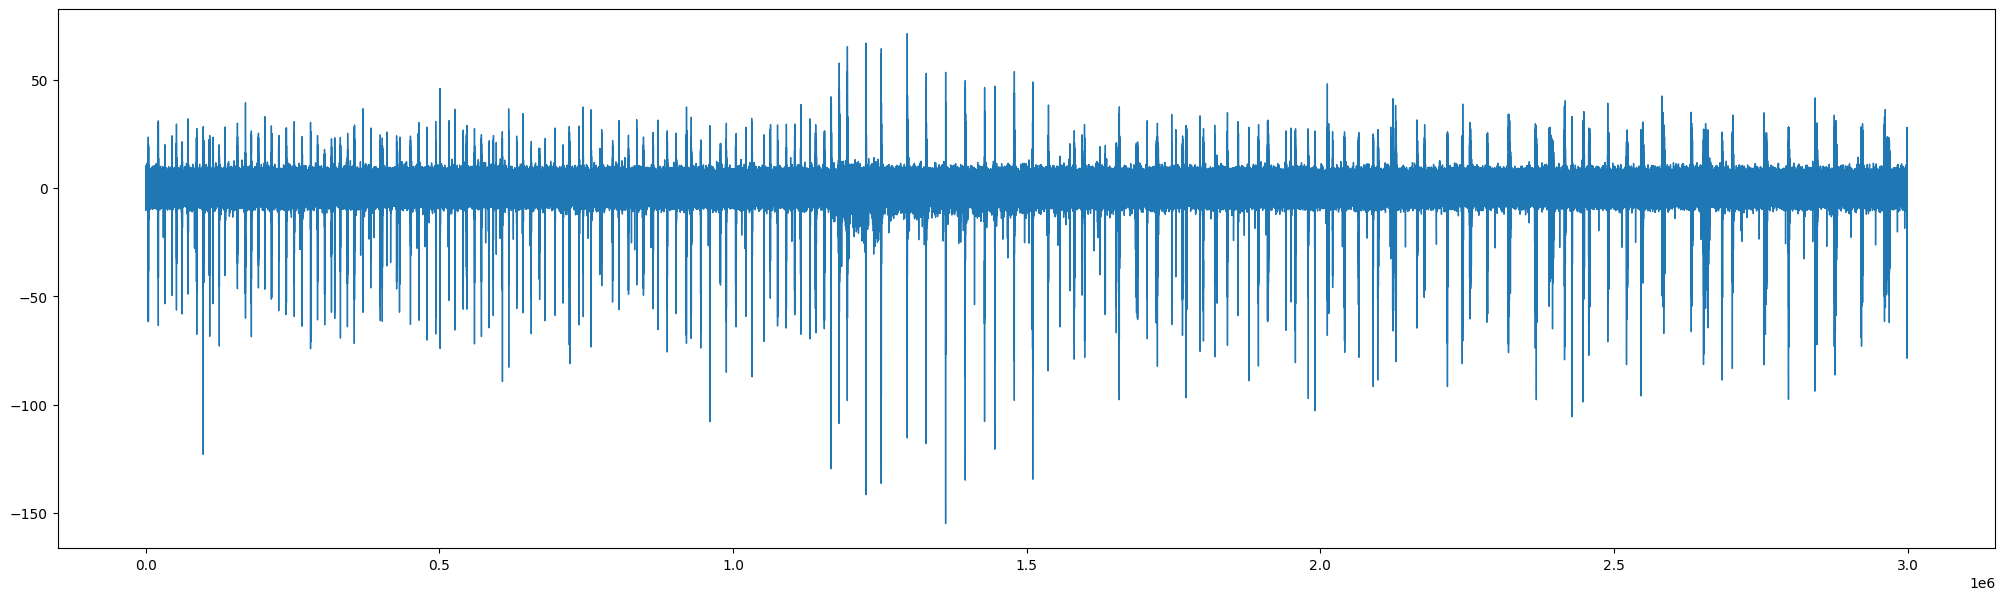

In [5]:
plt.figure(figsize=(25,7))
plt.plot(raw_df['A06'], linewidth = 1)
plt.show()

# Data Pre-Processing

variables

In [6]:
neurons = ['A06'] # neurons data

n_data_points = 5 # number of data points considered for training # V n=2, 1<t<10
t_data_points = 5 # number of FUTURE data points in which is predicted if there is a spike or no

In [7]:
raw_df = raw_df[neurons]

raw_data = raw_df.values.T

raw_data.shape

(1, 2999000)

Scaling

In [8]:
# scaler = StandardScaler()
# raw_data = scaler.fit_transform(raw_data)

Split RAW data; Input-Output

In [9]:
smaller_parts = []
samp = []

labels = []

# Split each sample into smaller parts
for sample in range(0, raw_data.shape[0]):  # Transpose the array to iterate over samples
    num_parts = raw_data[sample].shape[0] // n_data_points
    for i in range(num_parts-1):
        raw_part = raw_data[sample][i * n_data_points: (i + 1) * n_data_points]
        smaller_parts.append(raw_part)
        future = raw_data[sample][(i + 1) * n_data_points : ((i + 1) * n_data_points + t_data_points)]
        labels.append(future)

# Convert the list of smaller parts to a NumPy array
raw_split_data = np.array(smaller_parts)
labels = np.array(labels)

raw_split_data.shape, labels.shape

((599799, 5), (599799, 5))

In [10]:
labels

array([[ -1.06694197,  -2.95903182,  -5.2173326 ,  -1.98246932,
         -5.58354353],
       [  0.33686662,   0.82514787,  -3.14213728,  -3.69145369,
         -4.54594588],
       [ -2.59282088,  -3.38627791,  -3.69145369,  -5.52250838,
         -5.2173326 ],
       ...,
       [  8.94282365,   3.14448381,   8.75971818,   9.61421037,
          2.53413225],
       [ -3.93559432, -10.6494615 ,  -6.98735213,  -6.37700057,
         -6.62114119],
       [-10.89360213, -13.579149  ,  -5.88871932,   2.53413225,
          1.43549943]])

In [11]:
raw_split_data = np.reshape(raw_split_data, (raw_split_data.shape[0], 1, raw_split_data.shape[1]))

# Test-Train split
wirth the same ratio of 0s and 1s in test and train data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(raw_split_data, labels, test_size=0.2, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (479839, 1, 5)
X_test shape: (119960, 1, 5)
y_train shape: (479839, 5)
y_test shape: (119960, 5)


In [13]:
y_test[143]

array([ 0.76411272,  2.53413225,  1.67964006, -0.39555525, -2.16557478])

# Model

In [14]:
model = Sequential()
model.add(GRU(n_data_points, input_shape=(1, n_data_points), return_sequences=True))  # Input layer
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, return_sequences=False))
model.add(Dense(8, activation='tanh'))
model.add(Dense(t_data_points, activation='linear'))  # Output layer with 5 neurons and linear activation (binary classification)

# Specify class weights
class_weights = {0: 1, 1: 200}

model.compile(optimizer='adam', loss='mse')


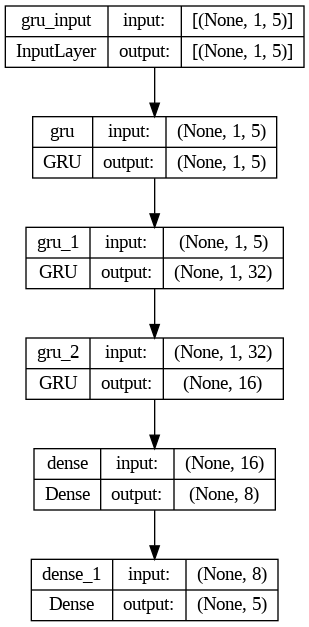

In [15]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

tf.keras.utils.plot_model(model, show_shapes=True)

class_weight=class_weights,

In [16]:
history_model = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
14995/14995 [==============================] - 124s 8ms/step - loss: 14.8805 - val_loss: 15.6927
Epoch 2/10
14995/14995 [==============================] - 113s 8ms/step - loss: 14.2726 - val_loss: 15.7381
Epoch 3/10
14995/14995 [==============================] - 113s 8ms/step - loss: 14.1951 - val_loss: 15.5594
Epoch 4/10
14995/14995 [==============================] - 116s 8ms/step - loss: 14.1540 - val_loss: 15.5946
Epoch 5/10
14995/14995 [==============================] - 117s 8ms/step - loss: 14.1109 - val_loss: 15.6413
Epoch 6/10
14995/14995 [==============================] - 112s 7ms/step - loss: 14.0865 - val_loss: 15.4415
Epoch 7/10
14995/14995 [==============================] - 116s 8ms/step - loss: 14.0672 - val_loss: 15.4794
Epoch 8/10
14995/14995 [==============================] - 114s 8ms/step - loss: 14.0361 - val_loss: 15.5121
Epoch 9/10
14995/14995 [==============================] - 115s 8ms/step - loss: 14.0208 - val_loss: 15.4586
Epoch 10/10
14995/14995 [===

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/models/model_GRU_notnorm_5_5_noShuff_A06.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/models/model_GRU_notnorm_5_5_noShuff_A06.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
pred = model.predict(X_test)

3749/3749 [==============================] - 12s 3ms/step


In [19]:
pred.shape

(119960, 5)

In [20]:
pred

array([[ 0.64921176,  0.5389842 ,  0.47559798,  0.4242394 ,  0.3794961 ],
       [ 0.05779326, -0.03612757, -0.09509361, -0.1228565 , -0.12865883],
       [ 0.94349205,  0.75412714,  0.6369717 ,  0.55393624,  0.48923934],
       ...,
       [13.11571   ,  7.5732374 ,  3.5056243 ,  1.5299454 ,  0.5880853 ],
       [ 3.2568917 ,  2.682372  ,  2.3174467 ,  2.0567808 ,  1.8137752 ],
       [-4.322513  , -3.5021653 , -2.946417  , -2.5802946 , -2.2825494 ]],
      dtype=float32)

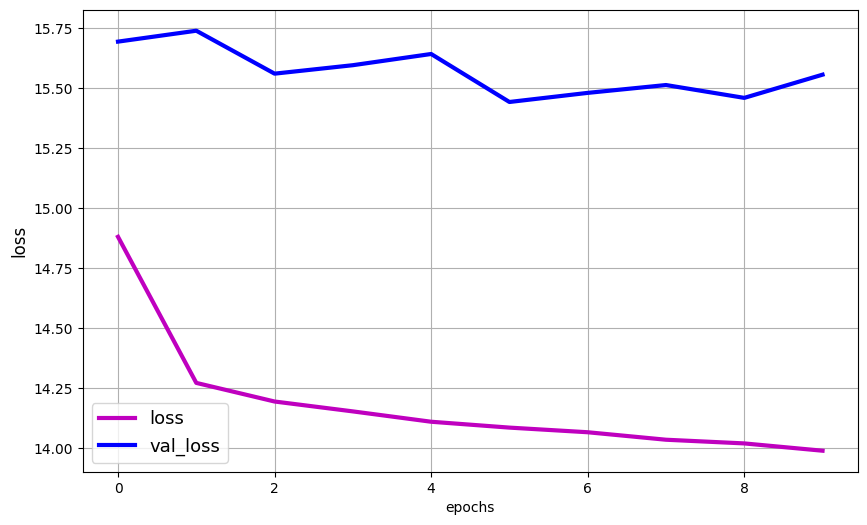

In [21]:
plt.figure(figsize=(10,6))
plt.plot(history_model.history['loss'], 'm', linewidth=3)
plt.plot(history_model.history['val_loss'], 'b', linewidth=3)
plt.legend(['loss', 'val_loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

In [22]:
pred.shape

(119960, 5)

In [23]:
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.570588017624467


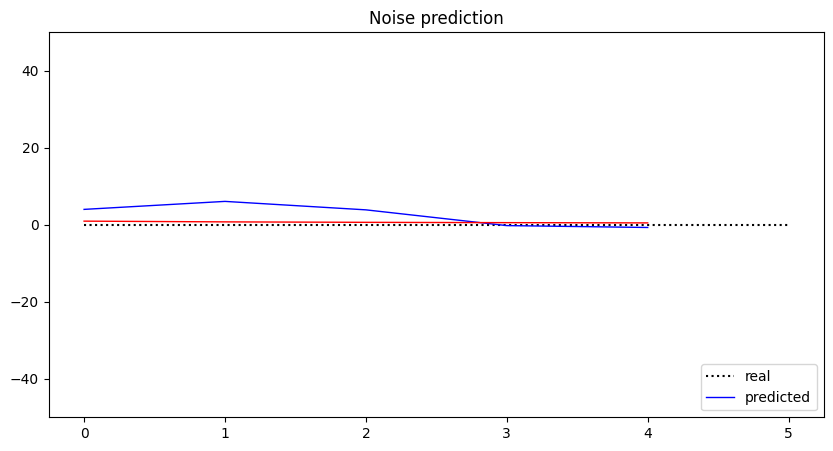

In [40]:
sample = 2

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=5, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["real", "predicted"], loc="lower right")
plt.title('Noise prediction')
plt.show()

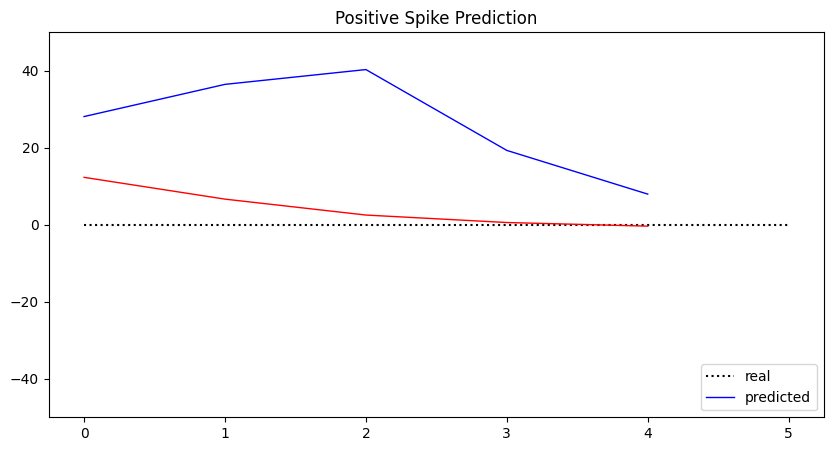

In [41]:
sample = 3537

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=5, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["real", "predicted"], loc="lower right")
plt.title('Positive Spike Prediction')
plt.show()

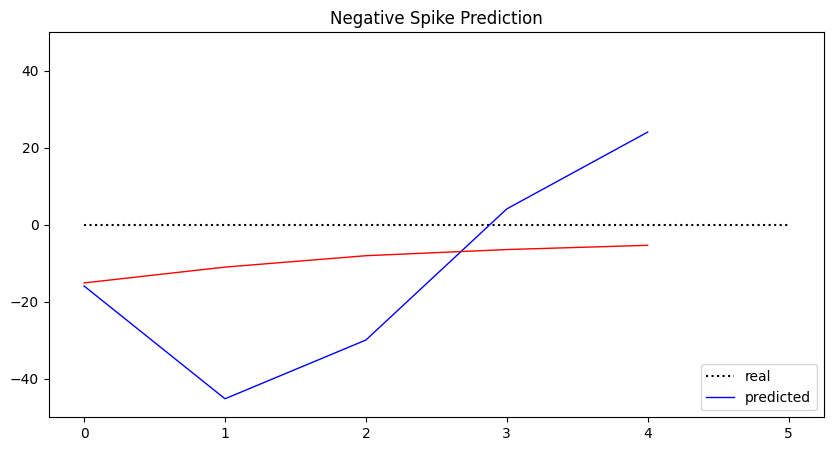

In [42]:
sample = 9875

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=5, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["real", "predicted"], loc="lower right")
plt.title('Negative Spike Prediction')
plt.show()

In [27]:
for a in range(0, 10000):
  if max(y_test[a]) > 20:
    print(a, '- - ', y_test[a])

3241 - -  [-1.49418807  4.48725725 12.84907365 25.78852678 37.69038225]
3251 - -  [11.01801897  8.33247209 20.90571428 17.60981584  1.67964006]
3274 - -  [14.7411635  18.76948381 23.95747209 27.0092299  22.1264174 ]
3283 - -  [24.20161272 20.1732924   8.75971818  6.68452287 -0.27348494]
3305 - -  [14.80219865 21.02778459 17.06049943 11.99458147 10.10249162]
3309 - -  [16.14497209 19.31880022 12.91010881 13.64253068 20.66157365]
3310 - -  [26.09370256 16.81635881  9.49214006  6.74555803  9.24799943]
3379 - -  [18.09809709 26.09370256 22.37055803 15.35151506 13.45942522]
3432 - -  [16.02290178 21.1498549   8.39350725  2.47309709  1.49653459]
3465 - -  [ 5.70796037  3.5717299   7.35590959  9.67524553 25.483351  ]
3492 - -  [-9.91703963  2.90034318 14.80219865 26.09370256 29.69477678]
3493 - -  [ 21.577101    14.61909318  -4.17973494 -18.27885603 -10.22221541]
3494 - -  [12.23872209 21.1498549  12.48286272 -4.42387557 -7.78080916]
3501 - -  [15.10737443 17.12153459 15.96186662 15.53462053 